In [ ]:
!pip install pycaret -q

In [ ]:
!pip install pandas-profiling==2.8.0  -q

In [ ]:
!pip install AutoViz -q

In [43]:
import pandas as pd
import pycaret
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling



In [44]:
dataset=pd.read_excel('/content/Data_Train.xlsx')

In [45]:
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [47]:
pandas_profiling.ProfileReport(dataset,minimal=True)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [105]:
profile=pandas_profiling.ProfileReport(dataset)

In [106]:
profile.to_file("fli8_price_EDA.html")

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
dataset.drop_duplicates(keep='first',inplace=True)

In [49]:
dataset.shape #(10463, 11)

(10463, 11)

In [50]:
dataset.dropna(inplace=True)

In [51]:
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

**EDA**

From description we can see that Date_of_Journey is a object data type,Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas to_datetime to convert object data type to datetime dtype.

dt.day method will extract only day of that date

dt.month method will extract only month of that date

In [52]:
dataset["Journey_day"] = pd.to_datetime(dataset.Date_of_Journey, format="%d/%m/%Y").dt.day

In [53]:
dataset["Journey_month"] = pd.to_datetime(dataset["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [54]:
dataset["Week_day"] = pd.to_datetime(dataset["Date_of_Journey"], format = "%d/%m/%Y").dt.day_name()

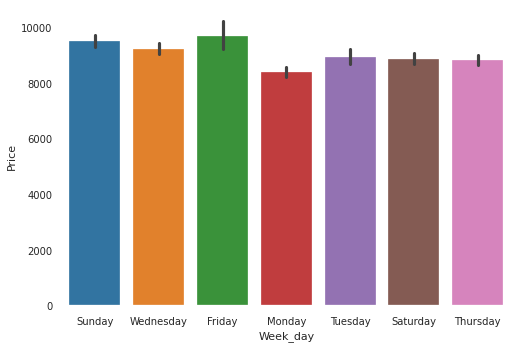

In [55]:
#now lets check the day of the journey relation with the output price column
sns.barplot('Week_day','Price',data=dataset)

In [56]:
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Week_day
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,Sunday
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,Wednesday
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,Sunday
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,Sunday
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,Friday


In [57]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.

dataset.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [58]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
dataset["Dep_hour"] = pd.to_datetime(dataset["Dep_Time"]).dt.hour

# Extracting Minutes
dataset["Dep_min"] = pd.to_datetime(dataset["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
dataset.drop(["Dep_Time"], axis = 1, inplace = True)

In [59]:
dataset.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Week_day,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,Sunday,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,Wednesday,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,Sunday,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,Sunday,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,Friday,16,50


In [60]:

# Extracting Hours
dataset["Arrival_hour"] = pd.to_datetime(dataset.Arrival_Time).dt.hour

# Extracting Minutes
dataset["Arrival_min"] = pd.to_datetime(dataset.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
dataset.drop(["Arrival_Time"], axis = 1, inplace = True)

In [61]:
dataset.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Week_day,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,Sunday,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,Wednesday,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,Sunday,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,Sunday,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,Friday,16,50,21,35


In [62]:
#For the duration column which is in a hour and min format lets convert it into minutes using a equation 
dataset['Duration']=dataset['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
#now lets convert this column into a numeric
dataset['Duration']=pd.to_numeric(dataset['Duration'])

In [63]:
dataset.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Week_day,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,Sunday,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,1,5,Wednesday,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,9,6,Sunday,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,12,5,Sunday,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,1,3,Friday,16,50,21,35


In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Route            10462 non-null  object
 4   Duration         10462 non-null  int64 
 5   Total_Stops      10462 non-null  object
 6   Additional_Info  10462 non-null  object
 7   Price            10462 non-null  int64 
 8   Journey_day      10462 non-null  int64 
 9   Journey_month    10462 non-null  int64 
 10  Week_day         10462 non-null  object
 11  Dep_hour         10462 non-null  int64 
 12  Dep_min          10462 non-null  int64 
 13  Arrival_hour     10462 non-null  int64 
 14  Arrival_min      10462 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 1.6+ MB


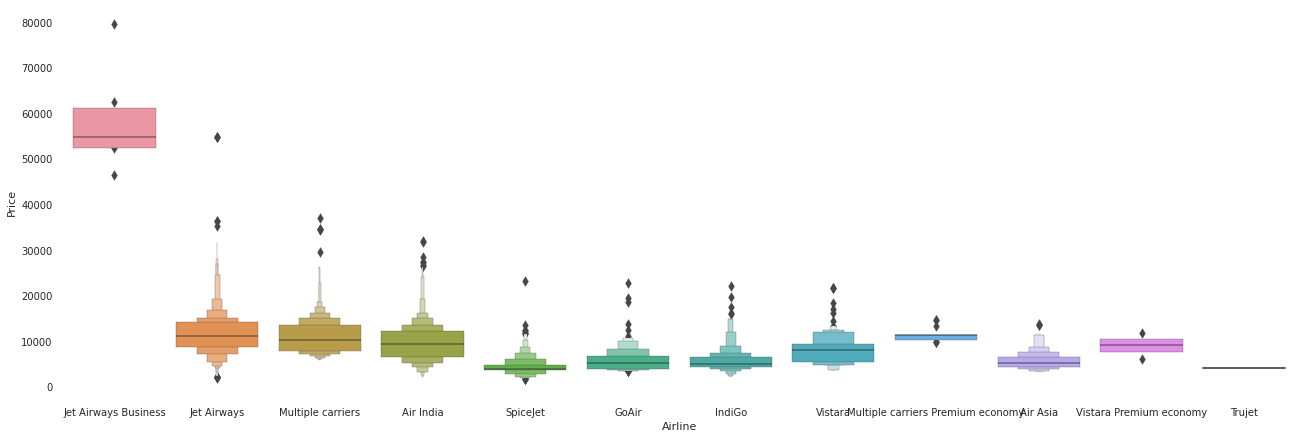

In [65]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = dataset.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

Airline ,source,Destination- one hot encoding


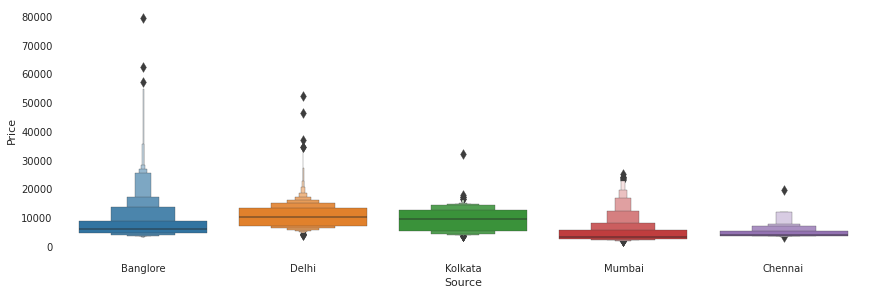

In [66]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = dataset.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

# so we cant tell which source is better so use one hot encoding

In [67]:
dataset["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10462, dtype: object

additional onfo has almost 80% no info so lets drop it

and stops and route are related so lets drop route

In [68]:
dataset.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

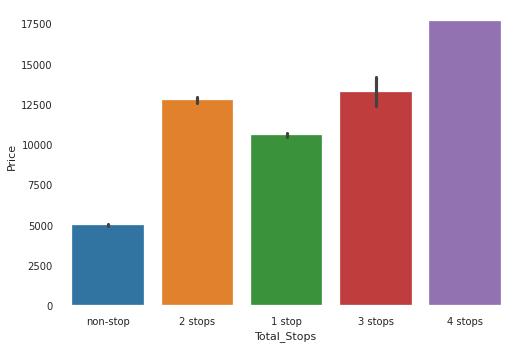

In [69]:
sns.barplot(x='Total_Stops',y='Price',data=dataset)

so total_stop is an ordinal feature

In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Airline        10462 non-null  object
 1   Source         10462 non-null  object
 2   Destination    10462 non-null  object
 3   Duration       10462 non-null  int64 
 4   Total_Stops    10462 non-null  object
 5   Price          10462 non-null  int64 
 6   Journey_day    10462 non-null  int64 
 7   Journey_month  10462 non-null  int64 
 8   Week_day       10462 non-null  object
 9   Dep_hour       10462 non-null  int64 
 10  Dep_min        10462 non-null  int64 
 11  Arrival_hour   10462 non-null  int64 
 12  Arrival_min    10462 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 1.4+ MB


In [71]:
dataset.shape

(10462, 13)

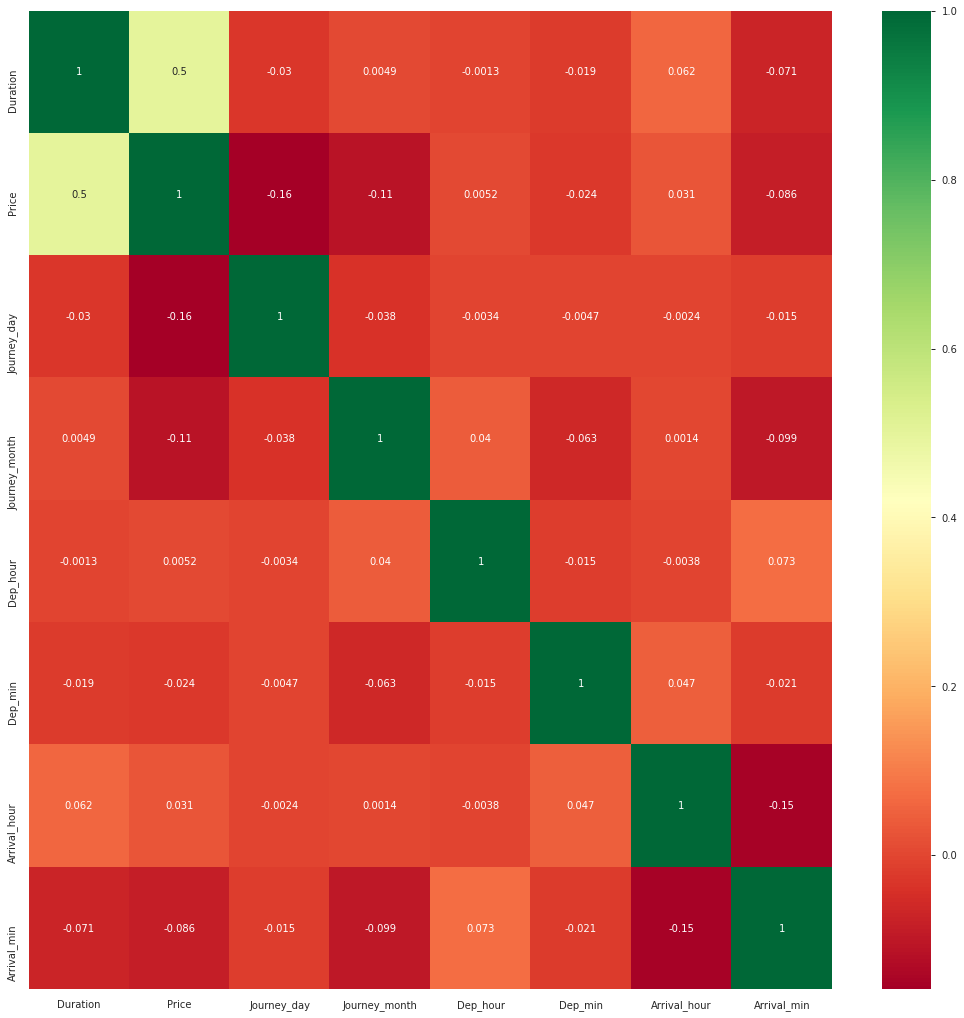

In [72]:

plt.figure(figsize = (18,18))
sns.heatmap(dataset.corr(), annot = True, cmap = "RdYlGn")

In [73]:
data=dataset.sample(frac=0.9,random_state=786)
data_unseen=dataset.drop(data.index)
data.reset_index(drop=True,inplace=True)
data_unseen.reset_index(drop=True,inplace=True)

In [74]:
data.to_csv('/content/data_seen.csv')

In [75]:
data_unseen.to_csv('/content/data_unseen.csv')

In [90]:
from pycaret.regression import*

In [92]:
flight_pre=setup(data=data,target='Price',
                 ordinal_features={'Total_Stops':['non-stop','1 stop','2 stops','3 stops','4 stops']},
                 categorical_features=['Airline','Source','Destination','Week_day'],
                 numeric_features=['Arrival_min','Arrival_hour','Dep_min','Dep_hour','Journey_month','Journey_day','Duration'],
                 normalize=True,transformation=True,
                  remove_multicollinearity=True,
                  remove_outliers=True,
                  categorical_imputation="mode",
                  ignore_low_variance=True,
                                          )

,Description,Value
0,session_id,944
1,Target,Price
2,Original Data,"(9416, 13)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,5
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6261, 30)"


In [93]:
#flight_pre[21].shape # after setup dimension of dataset

In [94]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1243.6538,3.739760e+06,1915.6515,0.8179,0.1787,0.1383,1.941
lightgbm,Light Gradient Boosting Machine,1309.9410,4.001025e+06,1982.9509,0.8048,0.1871,0.1471,0.115
xgboost,Extreme Gradient Boosting,1270.9916,4.186723e+06,2025.3550,0.7965,0.1869,0.1394,6.176
rf,Random Forest Regressor,1256.3079,4.410116e+06,2080.7540,0.7847,0.1913,0.1356,2.035
et,Extra Trees Regressor,1294.1584,4.782537e+06,2175.6732,0.7643,0.2062,0.1395,1.736
gbr,Gradient Boosting Regressor,1549.0114,5.248053e+06,2268.6377,0.7445,0.2171,0.1774,0.562
knn,K Neighbors Regressor,1592.0606,5.876793e+06,2404.8027,0.7128,0.2322,0.1824,0.120
dt,Decision Tree Regressor,1489.4867,8.246210e+06,2835.4870,0.5964,0.2450,0.1598,0.043
br,Bayesian Ridge,2014.0346,8.348704e+06,2874.3491,0.5899,0.3011,0.2438,0.025
lar,Least Angle Regression,2014.8754,8.348252e+06,2874.3710,0.5899,0.3032,0.2441,0.023


In [95]:
catboost=create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1250.1733,4.294637e+06,2072.3507,0.8014,0.1777,0.1369
1,1173.7600,2.978895e+06,1725.9476,0.8290,0.1705,0.1315
2,1342.0884,5.216041e+06,2283.8653,0.7768,0.1919,0.1438
3,1191.3139,2.664238e+06,1632.2493,0.8478,0.1742,0.1367
4,1201.2268,2.742345e+06,1656.0026,0.8467,0.1698,0.1334
5,1229.4331,3.029145e+06,1740.4440,0.8328,0.1706,0.1356
6,1242.1515,3.064486e+06,1750.5673,0.8357,0.1830,0.1397
7,1284.3936,5.115225e+06,2261.6863,0.7926,0.1824,0.1401
8,1215.5027,3.011123e+06,1735.2587,0.8449,0.1732,0.1359
9,1306.4943,5.281461e+06,2298.1430,0.7716,0.1940,0.1493


In [96]:
tuned_catboost=tune_model(catboost,optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1388.2101,5.021615e+06,2240.8960,0.7677,0.1934,0.1548
1,1253.0992,3.197752e+06,1788.2261,0.8164,0.1831,0.1451
2,1494.2727,6.406083e+06,2531.0240,0.7258,0.2130,0.1624
3,1316.5081,3.197792e+06,1788.2370,0.8173,0.1934,0.1538
4,1291.5575,3.046093e+06,1745.3061,0.8297,0.1803,0.1459
5,1322.4439,3.310281e+06,1819.4177,0.8173,0.1873,0.1511
6,1377.8671,3.543328e+06,1882.3730,0.8100,0.2007,0.1592
7,1380.4763,5.493968e+06,2343.9214,0.7773,0.1963,0.1562
8,1326.3634,3.338108e+06,1827.0490,0.8281,0.1853,0.1515
9,1471.0227,6.116521e+06,2473.1601,0.7355,0.2095,0.1681


In [97]:
final=finalize_model(tuned_catboost)

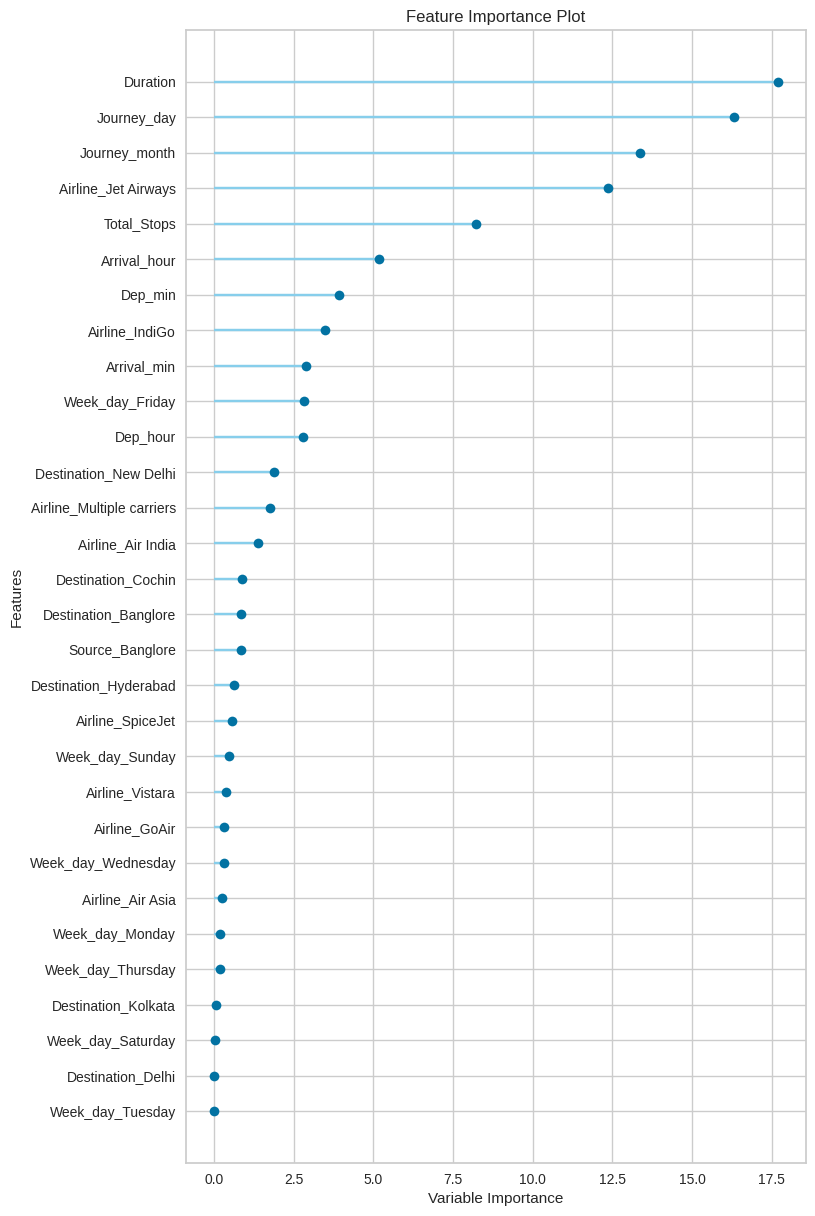

In [98]:
plot_model(final,plot="feature_all")

In [99]:
save_model(final,'final_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Airline', 'Source',
                                                             'Destination',
                                                             'Week_day'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['Arrival_min',
                                                           'Arrival_hour',
                                                           'Dep_min', 'Dep_hour',
                                                           'Journey_month',
                                                           'Journey_day',
                                                           'Duration'],
                                       target='Price', time_features=[])),
                 ('...
        

In [100]:
pred_df=pd.read_csv('/content/data_unseen.csv')

In [101]:
predicted_df=predict_model(final,data=pred_df)

In [102]:
predicted_df

,Unnamed: 0,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_day,Journey_month,Week_day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Label
0,0,SpiceJet,Kolkata,Banglore,145,non-stop,3873,24,6,Monday,9,0,11,25,3952.069331
1,1,Air India,Delhi,Cochin,1380,2 stops,13381,12,6,Wednesday,20,15,19,15,11971.530446
2,2,Air India,Kolkata,Banglore,150,non-stop,6245,18,5,Saturday,14,15,16,45,5294.730056
3,3,Jet Airways,Delhi,Cochin,715,1 stop,14924,3,6,Monday,7,5,19,0,12780.735390
4,4,Vistara,Chennai,Kolkata,135,non-stop,7414,6,3,Wednesday,7,5,9,20,6903.747022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1041,Vistara,Banglore,New Delhi,175,non-stop,4878,21,3,Thursday,21,10,0,5,6489.953707
1042,1042,Air India,Delhi,Cochin,375,1 stop,8372,9,5,Thursday,13,0,19,15,9183.543762
1043,1043,Jet Airways,Delhi,Cochin,1025,2 stops,11733,6,6,Thursday,19,30,12,35,12833.585146
1044,1044,Jet Airways,Delhi,Cochin,440,2 stops,21219,9,5,Thursday,11,40,19,0,17603.439403


In [103]:
predicted_df.to_csv('/content/predicted_df.csv')

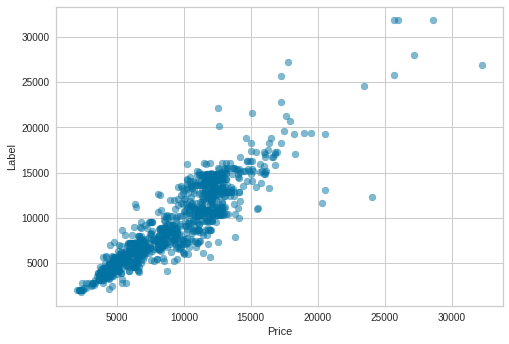

In [104]:
plt.scatter('Label', 'Price', alpha = 0.5,data=predicted_df)
plt.xlabel("Price")
plt.ylabel("Label")
plt.show()